In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os
from datetime import datetime
%load_ext tensorboard

In [ ]:
import tensorflow as tf
import gc
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dropout,ZeroPadding2D, Add, GlobalAveragePooling2D, DepthwiseConv2D, Activation, BatchNormalization, Dropout, LSTM, ConvLSTM2D, AveragePooling2D, Flatten, Dense, Input,Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation, LSTM, ConvLSTM2D, Lambda, Reshape, BatchNormalization, Bidirectional


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,TensorBoard,TerminateOnNaN, LearningRateScheduler
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from sklearn.metrics import precision_recall_curve,  plot_precision_recall_curve,  classification_report,  confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from imutils import paths

In [ ]:
!unzip "/content/drive/MyDrive/out.zip" -d "./"

Streaming output truncated to the last 5000 lines.
  inflating: ./out/val/covid/COVID-19 (37).jpg  
  inflating: ./out/val/covid/COVID-19 (84).jpg  
  inflating: ./out/val/covid/COVID-19 (238).jpg  
  inflating: ./out/val/covid/099.jpeg  
  inflating: ./out/val/covid/COVID-19 (227).jpg  
  inflating: ./out/val/covid/043.JPG  
  inflating: ./out/val/covid/479.jpg  
  inflating: ./out/val/covid/COVID-19 (642).jpg  
  inflating: ./out/val/covid/COVID-19 (12).jpg  
  inflating: ./out/val/covid/COVID-19 (645).jpg  
  inflating: ./out/val/covid/COVID19(452).jpg  
  inflating: ./out/val/covid/159.jpeg  
  inflating: ./out/val/covid/117.jpeg  
  inflating: ./out/val/covid/COVID-19 (606).jpg  
  inflating: ./out/val/covid/COVID-19 (39).jpg  
  inflating: ./out/val/covid/COVID-19 (16).jpeg  
  inflating: ./out/val/covid/383.PNG  
  inflating: ./out/val/covid/COVID-19 (757).jpg  
  inflating: ./out/val/covid/067.jpeg  
  inflating: ./out/val/covid/217.jpg  
  inflating: ./out/val/covid/COVID19(40

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=15, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
test_generator = test_datagen.flow_from_directory(
    directory=r"./out/test/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)

train_generator = train_datagen.flow_from_directory(
        directory=r"./out/train/",
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=16,
        class_mode="categorical",
        shuffle=True,
        seed=42
    )

valid_generator = val_datagen.flow_from_directory(
        directory=r"./out/val/",
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=16,
        class_mode="categorical",
        shuffle=True,
        seed=42
    )

Found 1379 images belonging to 3 classes.
Found 4830 images belonging to 3 classes.
Found 693 images belonging to 3 classes.


In [ ]:
class_to_label_map = {'pneumonia' : 2, 'covid' : 1, 'normal' : 0}

In [ ]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential

In [ ]:
input_shape = (299,299,3)
base_model = tf.keras.applications.InceptionV3(weights='imagenet', input_shape=input_shape, include_top=False)
for layer in base_model.layers:
    layer.trainable = False
    

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(4096, 
                activation = 'relu'
                #kernel_regularizer= keras.regularizers.l2(l2=0.1)
                ))
model.add(BatchNormalization())
model.add(Dense(4096, 
                activation = 'relu'
                #kernel_regularizer= keras.regularizers.l2(l2=0.1)
                ))
#model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 4096)              8392704   
_________________________________________________________________
batch_normalization_188 (Bat (None, 4096)              16384     
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 1

In [ ]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Creating LR Scheduler
initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=755,
    decay_rate=0.9,
    staircase=True)

METRICS = ['accuracy',
           tf.keras.metrics.AUC(name="AUC"),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')
    ]


model.compile(optimizer= Adam(lr_schedule), loss='binary_crossentropy', metrics=METRICS)

#callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history = model.fit(train_generator,
                    epochs=15,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    validation_data = valid_generator,
                    validation_steps = valid_generator.n//valid_generator.batch_size,
                    #class_weight=class_weight,
                   )

Epoch 1/15
247/301 [=======================>......] - ETA: 20s - loss: 0.7836 - accuracy: 0.8010 - AUC: 0.8960 - precision: 0.8037 - recall: 0.7970

KeyboardInterrupt: ignored

In [ ]:
model.evaluate(test_generator)

1379/1379 [==============================] - 30s 21ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - AUC: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00


[0.0, 0.0, 0.0, 0.0, 0.0]

In [ ]:
model.evaluate(valid_generator)

44/44 [==============================] - 11s 248ms/step - loss: 0.1725 - accuracy: 0.9278 - AUC: 0.9705 - precision: 0.9319 - recall: 0.9278


[0.17245806753635406,
 0.9278499484062195,
 0.9704752564430237,
 0.9318840503692627,
 0.9278499484062195]

In [ ]:
for layer in base_model.layers[:165]:
    layer.trainable = False
for layer in base_model.layers[165:]:
    layer.trainable = True

In [ ]:
# Learning Rate
initial_learning_rate = 1e-5

# Learning Rate Scheduler
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=755,
    decay_rate=0.9,
    staircase=True)

# Creating Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5",
                                                    save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_recall', mode='max',patience=4,
                                                     restore_best_weights=True)

model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),  # Very slow learning rate
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)

In [ ]:
from keras.callbacks import EarlyStopping

history_new = model.fit(train_generator,
                        epochs=20,
                        steps_per_epoch = 4834 // 32,
                        validation_data = valid_generator,
                        validation_steps = 624 // 32,
                        callbacks=[checkpoint_cb, early_stopping_cb],)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


151/151 [==============================] - 74s 460ms/step - loss: 0.1009 - accuracy: 0.9470 - AUC: 0.9837 - precision: 0.9444 - recall: 0.9411 - val_loss: 0.1716 - val_accuracy: 0.9441 - val_AUC: 0.9777 - val_precision: 0.9439 - val_recall: 0.9408


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
151/151 [==============================] - 68s 450ms/step - loss: 0.1005 - accuracy: 0.9470 - AUC: 0.9875 - precision: 0.9505 - recall: 0.9462 - val_loss: 0.4256 - val_accuracy: 0.8750 - val_AUC: 0.9355 - val_precision: 0.8808 - val_recall: 0.8750
Epoch 3/20
151/151 [==============================] - 67s 446ms/step - loss: 0.1308 - accuracy: 0.9346 - AUC: 0.9851 - precision: 0.9365 - recall: 0.9334 - val_loss: 0.2039 - val_accuracy: 0.9309 - val_AUC: 0.9678 - val_precision: 0.9309 - val_recall: 0.9309
Epoch 4/20
151/151 [==============================] - 68s 451ms/step - loss: 0.0983 - accuracy: 0.9466 - AUC: 0.9878 - precision: 0.9503 - recall: 0.9421 - val_loss: 0.1347 - val_accuracy: 0.9309 - val_AUC: 0.9816 - val_precision: 0.9371 - val_recall: 0.9309
Epoch 5/20
151/151 [==============================] - 68s 453ms/step - loss: 0.0913 - accuracy: 0.9483 - AUC: 0.9906 - precision: 0.9493 - recall: 0.9462 - val_loss: 0.1490 - val_accuracy: 0.9211 - val_AUC: 0.9784 - val_pre

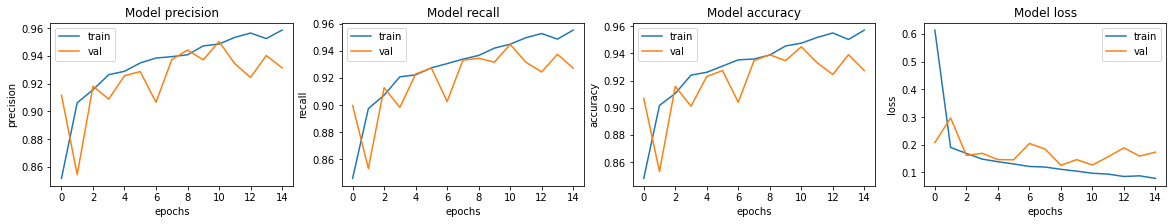

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
model.evaluate(valid_generator)

44/44 [==============================] - 11s 244ms/step - loss: 0.1742 - accuracy: 0.9365 - AUC: 0.9733 - precision: 0.9377 - recall: 0.9336


[0.17421433329582214,
 0.9365079402923584,
 0.9733009338378906,
 0.9376811385154724,
 0.9336219429969788]

In [ ]:
model.evaluate(test_generator)

1379/1379 [==============================] - 27s 19ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - AUC: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00


[0.0, 0.0, 0.0, 0.0, 0.0]

In [ ]:
y_true=test_generator.classes[test_generator.index_array] 

In [ ]:
y_pred = np.squeeze(model.predict_classes(test_generator))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       453
           1       0.90      0.90      0.90       463
           2       0.96      0.92      0.94       463

    accuracy                           0.93      1379
   macro avg       0.93      0.93      0.93      1379
weighted avg       0.93      0.93      0.93      1379



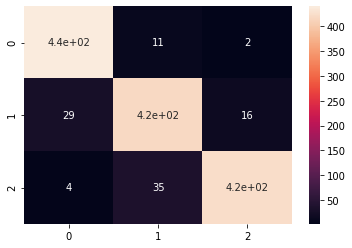

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


sns.heatmap(confusion_matrix(y_true,y_pred),annot=True)

In [ ]:
cm = confusion_matrix(y_true,y_pred)

tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))